In [19]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler 
from mpl_toolkits.mplot3d import Axes3D 
 
data = pd.read_csv(r"C:\Users\user\OneDrive\Desktop\projects\ML_Labs\tp3\HousingData.csv") 
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


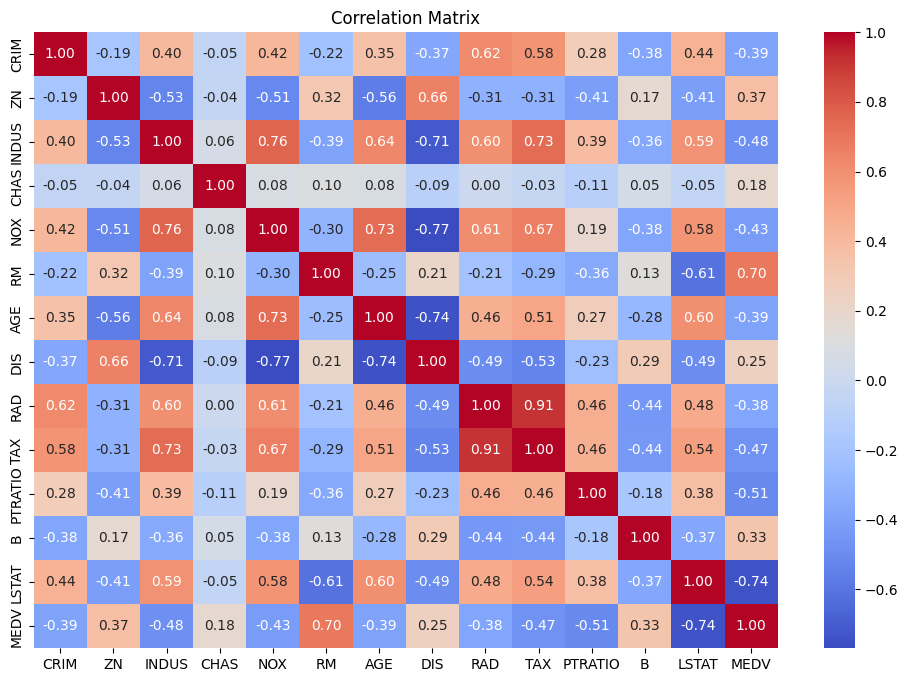

In [20]:

correlation_matrix = data.corr() 
plt.figure(figsize=(12, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f") 
plt.title("Correlation Matrix") 
plt.show() 


# 2.

In [21]:
 
target = 'MEDV' 
highly_corr_features = correlation_matrix[target][abs(correlation_matrix[target]) > 0.6].index 
highly_corr_data = data[highly_corr_features] 
 
print("Highly correlated features with MEDV (threshold > 0.6):", highly_corr_features.tolist()) 


Highly correlated features with MEDV (threshold > 0.6): ['RM', 'LSTAT', 'MEDV']


# 3.

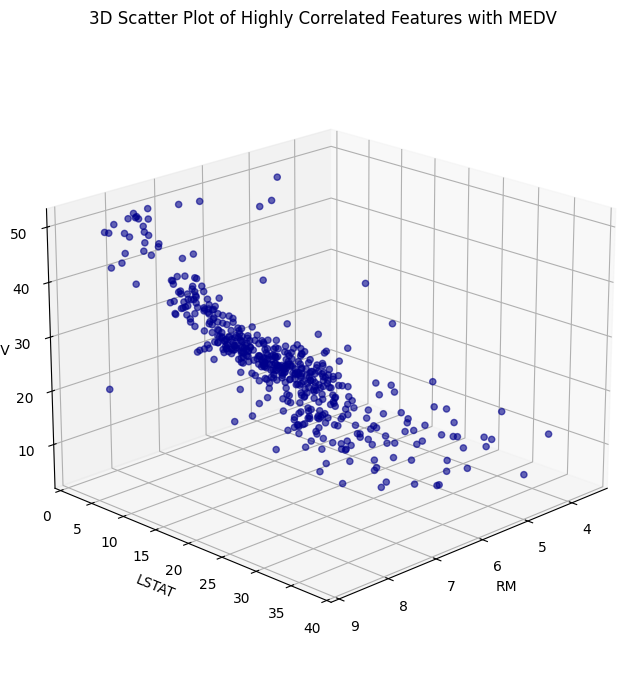

In [22]:
if len(highly_corr_features) == 3:  
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(highly_corr_data[highly_corr_features[0]], 
                        highly_corr_data[highly_corr_features[1]], 
                        data[target], 
                        c='darkblue', 
                        marker='o',
                        alpha=0.6)
    ax.set_xlabel(highly_corr_features[0], fontsize=10)
    ax.set_ylabel(highly_corr_features[1], fontsize=10)
    ax.set_zlabel(target, fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.title("3D Scatter Plot of Highly Correlated Features with MEDV", fontsize=12, pad=20)
    ax.view_init(elev=20, azim=45)
    plt.show()
else:
    print("Skipping 3D plot: need exactly two features highly correlated with MEDV.")

In [23]:
# Separate features and target
X = data.drop(target, axis=1)  
y = data[target]

# Split with stratification for better balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# MinMaxScaler scales all your features to be between 0 and 1
# This makes all features contribute equally to the modelscaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print("Data processing complete.")

Training set shape: (404, 13)
Test set shape: (102, 13)
Data processing complete.


### Real-world example:

Imagine your data has house features: size(1000-5000 sq ft) and age(0-100 years)
After scaling, both features will be between 0-1:
  * A 3000 sq ft house might become 0.5 (middle of range)
  * A 50-year-old house might become 0.5 (middle of range)
This makes the model treat both features equally, regardless of their original scales.

In [24]:
from sklearn.linear_model import SGDRegressor
sgdr = SGDRegressor(learning_rate='invscaling', eta0=0.0001,max_iter=1000,verbose=1)

In [26]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to train model and collect loss history
def train_model_with_history(sgdr, X, y, n_iter=1000):
    losses = []
    for _ in range(n_iter):
        # Randomly sample a batch
        indices = np.random.permutation(len(X))[:32]
        X_batch = X[indices]
        y_batch = y[indices]
        
        # Compute current prediction and loss
        y_pred = sgdr.predict(X_batch)
        current_loss = np.mean((y_pred - y_batch) ** 2)
        losses.append(current_loss)
        
        # Perform partial fit
        sgdr.partial_fit(X_batch, y_batch)
        
    return sgdr, losses

# Train models with different learning rates
learning_rates = [0.01, 0.001, 0.0001]
models = {}
loss_histories = {}

for lr in learning_rates:
    sgdr = SGDRegressor(
        learning_rate='invscaling',
        eta0=lr,
        max_iter=1000,
        tol=1e-3,
        random_state=42
    )
    model, history = train_model_with_history(sgdr, X_train_scaled, y_train)
    models[lr] = model
    loss_histories[lr] = history

# Plot convergence graphs
plt.figure(figsize=(12, 6))
for lr, history in loss_histories.items():
    plt.plot(history, label=f'Learning Rate = {lr}')
plt.xlabel('Iterations')
plt.ylabel('Loss (MSE)')
plt.title('Convergence Graph for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and display performance metrics
print("\nModel Performance Metrics:")
print("-" * 50)
print(f"{'Learning Rate':<15} {'MAE':>10} {'MSE':>10} {'RMSE':>10} {'R2':>10}")
print("-" * 50)

best_r2 = -float('inf')
best_model = None
best_lr = None

for lr, model in models.items():
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{lr:<15} {mae:>10.4f} {mse:>10.4f} {rmse:>10.4f} {r2:>10.4f}")
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_lr = lr

print(f"\nBest model: Learning Rate = {best_lr} (R² = {best_r2:.4f})")

# Find the two most important features based on correlation with target
correlation_with_target = abs(X_train.corr()[target])
top_features = correlation_with_target.nlargest(2).index

# Get indices of the top features
feature_indices = [X_train.columns.get_loc(col) for col in top_features]

# Plot 3D visualization for best model using top 2 features
feature_1 = X_train_scaled[:, feature_indices[0]]
feature_2 = X_train_scaled[:, feature_indices[1]]

# Create mesh grid for the plane
x_min, x_max = feature_1.min() - 0.1, feature_1.max() + 0.1
y_min, y_max = feature_2.min() - 0.1, feature_2.max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Create input array for prediction
X_plane = np.zeros((10000, X_train_scaled.shape[1]))
X_plane[:, feature_indices[0]] = xx.ravel()
X_plane[:, feature_indices[1]] = yy.ravel()

# Predict using the mesh grid
Z = best_model.predict(X_plane)
Z = Z.reshape(xx.shape)

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the plane
surf = ax.plot_surface(xx, yy, Z, alpha=0.3, cmap='viridis')

# Plot the training points
scatter = ax.scatter(feature_1, feature_2, y_train, c='r', marker='o')

ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_zlabel(target)
plt.title('3D Visualization of Best Model with Training Data')
plt.colorbar(surf)
plt.show()

KeyError: '[218, 104, 281, 173, 73, 30] not in index'